In [1]:
import pandas as pd
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.stats import sem

#%% Plot Tong's default setting
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE, family='sans-serif', serif='Arial')          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text')

from matplotlib.ticker import MaxNLocator
my_locator = MaxNLocator(6)

color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

def figure_size_setting(WIDTH):
    #WIDTH = 700.0  # the number latex spits out
    FACTOR = 0.8  # the fraction of the width you'd like the figure to occupy
    fig_width_pt  = WIDTH * FACTOR
    inches_per_pt = 1.0 / 72.27
    golden_ratio  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good
    fig_width_in  = fig_width_pt * inches_per_pt  # figure width in inches
    fig_height_in = fig_width_in * golden_ratio   # figure height in inches
    fig_dims    = [fig_width_in, fig_height_in] # fig dims as a list
    return fig_dims

In [2]:
########### import the pickled file containing all processed data which are useful for simulations (the processing is
########### done in "Trophic_model_for_gut_data_processing.ipynb")
import pickle
pickle_in = open("Chia_network.pickle","rb")
net, i_selfish, i_intake, names = pickle.load(pickle_in)

pickle_in = open("data.pickle","rb")
metagenome_ID, metagenome, metabolome_ID, metabolome = pickle.load(pickle_in)


## Create maps of microbes and metabolites to their reduced matrix forms

In [3]:
#i_nonzero_microbes = net['microbes_ID'].unique()
#i_nonzero_microbes = np.sort(i_nonzero_microbes)
i_nonzero_microbes = metagenome_ID.values.copy()
i_nonzero_metabolites = net['metabolites_ID'].unique()
i_nonzero_metabolites = np.sort(i_nonzero_metabolites)


df_metabolites = pd.DataFrame.from_dict({'oldID': i_nonzero_metabolites, 'newID':list(range(len(i_nonzero_metabolites)))})
df_metabolites.set_index('oldID', inplace=True)
df_microbes = pd.DataFrame.from_dict({'oldID': i_nonzero_microbes, 'newID':list(range(len(i_nonzero_microbes)))})
df_microbes.set_index('oldID', inplace=True)


outgoingNodes = df_metabolites.loc[net['metabolites_ID'].values].values.flatten()
ingoingNodesTemp = df_microbes.loc[net['microbes_ID'].values].values.flatten()
edge_types = net.iloc[~np.isnan(ingoingNodesTemp),2].values
outgoingNodes = outgoingNodes[~np.isnan(ingoingNodesTemp)]
ingoingNodes = ingoingNodesTemp[~np.isnan(ingoingNodesTemp)].astype(int)

net_reduced = pd.DataFrame.from_dict({'metabolites': outgoingNodes, 'microbes':ingoingNodes, 'edgeType':edge_types})
net = net_reduced.copy()
net_temp = net.copy()
net['edgeType'][net['edgeType']==5] = 2
net_temp['edgeType'][net_temp['edgeType']==5] = 3
net = net.append(net_temp).drop_duplicates()
net_ori = net.copy()

metagenome_ID_reduced = df_microbes.loc[metagenome_ID].values.flatten()
metagenome_ID = metagenome_ID_reduced[~np.isnan(metagenome_ID_reduced)].astype(int)

metabolome_ID_reduced = df_metabolites.loc[metabolome_ID].values.flatten()
metabolome_ID = metabolome_ID_reduced[~np.isnan(metabolome_ID_reduced)].astype(int)


i_selfish_reduced = df_microbes.loc[i_selfish].values.flatten()
i_selfish = i_selfish_reduced[~np.isnan(i_selfish_reduced)].astype(int)

i_intake_reduced = df_metabolites.loc[i_intake].values.flatten()
i_intake = i_intake_reduced[~np.isnan(i_intake_reduced)].astype(int)


/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app
/Users/tongwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [4]:
for i in range(1,101):
    df_deleted = pd.read_csv("./cluster_simulation_add_and_delete/deleted_links_prior_distribution_run"+str(i)+".csv", index_col=0)
    #df_deleted['metabolites'] = df_metabolites.loc[df_deleted['metabolite ID']].values
    #df_deleted['microbes'] = df_microbes.loc[df_deleted['microbes ID']].values
    #df_deleted_net = df_deleted[['metabolites','microbes','edgeType']]
    #df_deleted_net.head()
    if i == 1:
        df_deleted_all = df_deleted.copy()
    else:
        df_deleted_all = pd.concat([df_deleted_all, df_deleted])

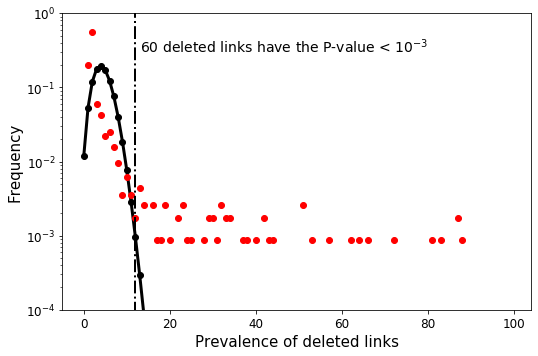

In [36]:
from collections import Counter
from scipy.stats import bernoulli, binom
NUMSIM = 100
xx = range(NUMSIM)
p = len(df_deleted_all) / 100 / len(net_ori)
probCum = binom.cdf(xx, NUMSIM, p)
prob = binom.pmf(xx, NUMSIM, p)
threshold = np.where(probCum > 1 - 1e-3)[0][0]

prevalence = Counter(df_deleted_all['position in x'])
numOfSigLinks = np.sum(np.array(list(prevalence.values())) >= threshold)

prevalence = Counter(prevalence.values())
fig_dims = figure_size_setting(700)
fig, axes = plt.subplots(1, 1, figsize=fig_dims, sharex=True)
axes.plot(xx, prob, 'ko-', lw=3)
axes.plot(list(prevalence.keys()), list(prevalence.values())/np.sum(list(prevalence.values())), 'ro')
axes.plot([threshold, threshold], [0, 1], 'k-.', lw=2)
axes.text(threshold+1, 0.3, str(numOfSigLinks)+' deleted links have the P-value < $10^{-3}$', size=14);
axes.set_yscale('log')
axes.set_ylim([1e-4, 1])
axes.set_xlabel('Prevalence of deleted links')
axes.set_ylabel('Frequency')
fig.subplots_adjust(left=.13, bottom=.11, right=.97, top=.97, hspace=0.2)
fig.savefig("./prevalence_of_deleted_links.pdf", dpi=600)

In [32]:
i_prevalent = df_deleted_all.groupby('position in x').apply(len) 
df_prevalence = df_deleted_all.set_index('position in x').loc[i_prevalent[i_prevalent >= threshold].index]
df_prevalence = df_prevalence[['metabolite ID', 'metabolite names', 'microbes ID', 'microbes names', 'edgeType']].drop_duplicates()
df_prevalence['prevalence'] = i_prevalent.loc[df_prevalence.index]
df_prevalence.to_csv('prevalent_deleted_links.csv', index=None)
df_prevalence

,metabolite ID,metabolite names,microbes ID,microbes names,edgeType,prevalence
position in x,,,,,,
975,2014,Acetate,455,Eubacterium hallii,2,43
977,2014,Acetate,457,Eubacterium rectale,2,13
980,2014,Acetate,464,Faecalibacterium prausnitzii,2,28
996,2014,Acetate,953,Roseburia inulinivorans,2,16
1348,2019,"Adenosylcobalamin (Vitamin B12, Cobamide coenz...",812,Parabacteroides distasonis,2,13
2968,2046,Chenodeoxycholic acid (Chenodeoxycholate),134,Bacteroides thetaiotaomicron,2,64
2981,2046,Chenodeoxycholic acid (Chenodeoxycholate),314,Clostridium leptum,2,13
3112,2049,Cholic acid (Cholate),134,Bacteroides thetaiotaomicron,2,51
3393,2055,CO2,123,Bacteroides dorei,2,38


In [43]:
df_prevalent_added = pd.read_csv("SI_table1.csv")
print(np.sum(df_prevalent_added["edgeType"]=="production"))
print(np.sum(df_prevalent_added["edgeType"]=="consumption"))

174
119


The p-value of having 174 production links is 0.0005177426833737897


Text(0, 0.5, 'Frequency')

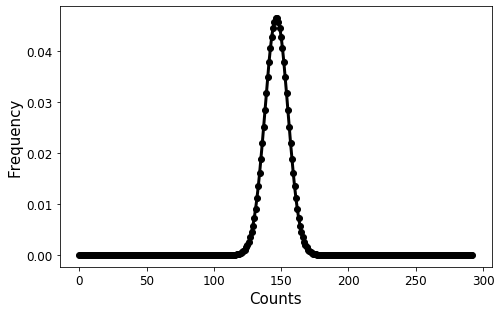

In [55]:
from collections import Counter
from scipy.stats import bernoulli, binom
count_of_production_links = np.sum(df_prevalent_added["edgeType"]=="production")
NUMSIM = len(df_prevalent_added)
xx = range(NUMSIM)
p = 0.5
probCum = binom.cdf(xx, NUMSIM, p)
prob = binom.pmf(xx, NUMSIM, p)
threshold = np.where(probCum > 1 - 1e-3)[0][0]
print('The p-value of having '+str(count_of_production_links)+' production links is',1 - probCum[count_of_production_links])

fig_dims = figure_size_setting(700)
fig, axes = plt.subplots(1, 1, figsize=fig_dims, sharex=True)
axes.plot(xx, prob, 'ko-', lw=3)
axes.set_xlabel('Counts')
axes.set_ylabel('Frequency')